## Agent Based Modeling (ABM): Forest Fire Model 1
-----------

This material is based on the previous version of CS108L, see https://cs4all.cs.unm.edu/cs108.html
- Credit to Prof. Melanie Moses, Dr. Irene Lee, Dr. Maureen Psaila-Dombrowski, Prof. Dave Ackley and collaborators (see website)

### Review: Computational Science 
- ABM is part of the much broader field of computational science (not computer science!)
- Computational science is the intersection of computer science, mathematices, and science (like biology, or chemistry, or physics)

<img src="https://raw.githubusercontent.com/jbschroder/CS108/main/lecture_images/venn_diagram.png" width="350">

### Review: Agent Based Modeling

<img src="https://raw.githubusercontent.com/jbschroder/CS108/main/lecture_images/agent_based_modeling.png" width="300">

### Learning Goals

1. Continue learning how to use Mesa ABM 
    1. How to use ABM
        - Conduct experiments by changing values and variables (like how flammable a tree is)
        - Collect and analyze results
    2. Learn how to modify ABM
    3. Learn how to create ABM
        
2. Continue practicing running multiple experiments with different numbers of steps and number of agents    
    
3. New: Forest fire model
    1. Agents are trees
    2. Trees are randomly scattered on a grid with a user-defined density
    3. Each step (iteration of the Runtime loop)
        - If a tree is on fire, all neighboring trees also catch fire
    
4. New: Collect statistics over time

### First, we have to make sure that Mesa is installed, and then import our basic packages
- Note that Pandas and Seaborn or "built-in" packages, so we only have to import them, not install them

In [1]:
! pip install mesa==2.1.1


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [2]:
%matplotlib inline

import mesa

# Data visualization tools.
import seaborn as sns

# Data manipulation and analysis.
import pandas as pd

import matplotlib.pyplot as plt


### Now, we can begin creating our forest fire model 

### First, we define  the TreeAgent (inherits from `mesa.Agent`)


- Each Step (iteration of the Runtime loop)
   - If a tree is on fire, all neighboring trees also catch fire
   - Remember that the model step calls each agent step in random order


In [3]:
# Create ABM

# 1. Define the Agent Abstraction
class TreeAgent(mesa.Agent):

    def __init__(self, model, pos):
        """
        Create a new tree.
        
        Parameters:
            model: the agent based model, within which this agent is acting
            
            pos: The tree's coordinates on the grid. Used as the unique_id
        """
        
        super().__init__(pos, model)
        self.pos = pos
        self.unique_id = pos
        self.condition = "No Fire"

    def step(self):
        """
        If the tree is on fire, spread it to `no fire` trees nearby.
        """
        if self.condition == "On Fire":
            neighbors = self.model.grid.get_neighbors(self.pos, moore=False)
            for neighbor in neighbors:
                if neighbor.condition == "No Fire":
                    neighbor.condition = "On Fire"
            self.condition = "Burned Out"

### Next, we define our ForestFireModel 
1. Randomly place trees on a grid according to a `density`

   For each square on the grid
    - If a random number between 0 and 1 is below `density`
    - Then place a tree in that square

   Thus, each grid cell in our forest has a `density` percent chance that a tree will be placed on it at the start of the simulation.


2. Store the spatial locations of the agents for animations in `agent_locations`

### The `ForestFireModel` defines two more of our key abstractions:
1. This defines the environment where the agents (trees) exist
2. This also defines how to take a step (tick) forward in time


In [4]:
# 2. Define the Model (or environment) Abstraction for the Agents to live in
class ForestFireModel(mesa.Model):
    """
    Simple Forest Fire model.
    """

    def __init__(self, width, height, density):
        """
        Create a new forest fire model.

        Args:
            width, height: The size of the grid to model
            density: What fraction of grid cells have a tree in them.
        """
        # Set up model objects
        self.schedule = mesa.time.RandomActivation(self)
        self.grid = mesa.space.SingleGrid(width, height, torus=False)
        self.width = width
        self.height = height
        
        # Save the spatial location of the agents in this list
        self.agent_locations = []
        
        # Store the number of trees with no fire, yes on fire, burned out 
        self.no_fire = []
        self.yes_fire = []
        self.burned_out = []
        
        # Place a tree in each cell with Prob = density
        for x in range(self.width):
            for y in range(self.height):
                if self.random.random() < density:
                    # Create a tree
                    new_tree = TreeAgent(self, (x, y))
                    # Set all trees in the first column on fire.
                    if x == 0:
                        new_tree.condition = "On Fire"
                    self.grid[x][y] = new_tree
                    self.schedule.add(new_tree)
                    
        self.running = True

    def step(self):
        """
        Advance the model by one step.
        """
        self.schedule.step()
            
        # Store spatial locations, and whether a tree is on fire or not
        import numpy as np
        agent_counts = np.zeros((self.grid.width, self.grid.height))
        for cell_content, (x, y) in self.grid.coord_iter():
            if cell_content == None:
                # No tree here, label 0
                agent_counts[x][y] = 0
            else: 
                # Now, we know that this cell has a tree and that cell_content is a tree agent
                if cell_content.condition == "No Fire":
                    agent_counts[x][y] = 1
                elif cell_content.condition == "On Fire":
                    agent_counts[x][y] = 2
                elif cell_content.condition == "Burned Out":
                    agent_counts[x][y] = 3
                    
        self.agent_locations.append(agent_counts)
        
        # Count the number of trees with no fire, yes on fire, burned out 
        count_no_fire = 0
        count_yes_fire = 0
        count_burned_out = 0
        for tree in self.schedule.agents:
            if tree.condition == "No Fire":
                count_no_fire += 1
            elif tree.condition == "On Fire":
                count_yes_fire += 1    
            elif tree.condition == "Burned Out":
                count_burned_out += 1    
        ##
        self.no_fire.append(count_no_fire)
        self.yes_fire.append(count_yes_fire)
        self.burned_out.append(count_burned_out)


### The below cell will generate animations.  
- Run this cell, to declare (define) this function
- This function is provided for you.  You only need to know how to use it. It generate animations of your agents as they move around on the grid.

In [5]:
# Run this cell
def plot_agents(model):
    import numpy as np
    import seaborn as sns
    import matplotlib.animation
    import matplotlib.pyplot as plt
    import matplotlib
    
    try:
      # if in a notebook, do inline
      get_ipython().run_line_magic('matplotlib', 'inline')
    except:
      pass

    plt.rcParams['figure.dpi'] = 72
    plt.rcParams["animation.html"] = "jshtml" # javascript html writer
    plt.ioff() # Turn interactive mode off
    plt.rcParams["figure.figsize"] = [7, 7]

    
    fig, ax = plt.subplots()
    global counter 
    counter = 0
    
    def animate(t):
        global counter
        agent_counts = model.agent_locations[t]
        
        cmap_dict = {0: '#FFFFFF', 1: '#00e400', 2: '#ff0000', 3: '#544c4a'}
        cmap = matplotlib.colors.ListedColormap([cmap_dict[i] for i in range(4)])
        
        # Plot using seaborn
        if counter == 0:
            g = sns.heatmap(agent_counts, vmin=0, vmax=3, cmap=cmap, cbar=True, square=True, ax=ax)
            c_bar = ax.collections[0].colorbar
            c_bar.set_ticks([0.5, 1.15, 1.9, 2.65])
            c_bar.set_ticklabels(['Empty', 'Tree', 'On Fire', 'Burned Out'])
        else:
            g = sns.heatmap(agent_counts, vmin=0, vmax=3, cmap=cmap, cbar=False, square=True, ax=ax)

        g.figure.set_size_inches(7, 7)
        g.set(title="Forest Fire Model")
        counter = counter+1

        
    anim = matplotlib.animation.FuncAnimation(fig, animate, frames=len(model.agent_locations), interval=200, repeat=False)
    return anim


## Running the model

Let's create a model with a 50 x 50 grid, and a tree density of 0.6. Remember, ForestFireModel takes the arguments *height*, *width*, *density*.
- height=50
- width=50
-density=0.6

Definition: Density is the percent chance that a tree occupies a grid cell at the start of the simulation

### Task: Run the below cells, generating the animation.
- Watch as the forest fire begins burning
- Does it finish burning?

### Task: Repeat this.  Observe how the fire pattern changes every time.  
- Try more steps than 50 (although this will make the animation take longer) 
- Observe how randomness works in practice!

Then, try different densities.  Experiment and observe :-)

In [6]:
fire_model = ForestFireModel(50, 50, 0.6)

In [7]:
for i in range(50):
    fire_model.step()

In [8]:
anim = plot_agents(fire_model)
anim

### Task: Enhance the model
- Add a new list to the `ForestFireModel` class that will track the percentage of the forest burned
   - Study how the lists `no_fire`, `yes_fire`, `burned_out` are used
    
    
   - You will mimic how these lists are used 
    
    
   - Let's call this list `percent_burned`.  Each step of the `ForestFireModel`, you will append a new value (betwen 0 and 1) to the list `percent_burned`. 
      - You will append 
      
              number of trees burned out / number of trees at beginning
              
      - Your three lists `no_fire`, `yes_fire`, `burned_out` contain all of the information needed


   - At the end of the simulation, the new list `fire_model.percent_burned` will have an entry for every step taken.
      - That is, `fire_model.percent_burned[k]` will contain the percent of the forest burned out after step `k`
    
    

### Task: Put this list into a Pandas dataframe and plot it 

To help you get started, here's how you would plot the number of trees on fire, not on fire, and burned out with Pandas.

You want to create a new (different) plot for `percent_burned`

<AxesSubplot: xlabel='time', ylabel='number of trees'>

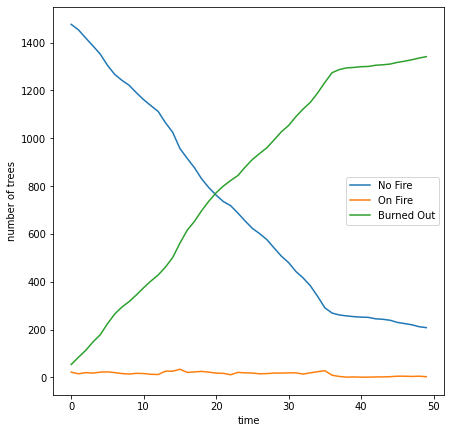

In [9]:
%matplotlib inline
results = pd.DataFrame({'No Fire': fire_model.no_fire, 'On Fire' : fire_model.yes_fire, 'Burned Out': fire_model.burned_out})
results.plot(xlabel='time', ylabel='number of trees')

### Task:  Create 4 or 5 new code cells below.  In each cell run an experiment with a different density.
  - For each experiment, plot the `percent_burned` data with Pandas

  - Each cell will contain code like
    
          ...
          fire_model = ForestFireModel(50, 50, ...some_density...)
          for i in range(50):
              fire_model.step()
          ...
          ... get percent_burned data from fire_model and plot ...


  - Make sure that you run enough steps.  50 is probably not always enough.


### Task: Discuss your results below according to the template.
  - If you have extra time, consider how different grid sizes affect the forest fire
  - That is, try 30 x 30 or 70 x 70, instead of 50 x 50

### Discussion template

1. Evidence acquisition 
     - Describe the experiments you conducted. Give all the details, number of agents, steps, abstractions used, and so on. 
     - You are describing application of a quantitative model (the agent based model)

2. Evidence evaluation 
    - Discuss your plots and any other results.  What did you find? 
    - You are communicating and representing quantitative information
    
3. Conclusion
    - What can you conclude?  
    - What is still unexplained? 

### In particular, here you want to focus on these questions
- What number of steps are needed to make sure the forest fire has stopped spreading?
    - How many steps do you need for quality evidence acquisition?

- How does density affect the forest fire model?  
    - Be specific, like, "A density of 0.5 represents a probability of 50% that a grid cell in our forest will have a tree in it at the start of the simulation.  With a density of 0.5, we see that the forest fire is likely to ..."

- Can this inform how we might manage a forest in real life?

Discussion goes here

Discuss your homework in at least 500 words.  Have sections for 

1. Evidence acquisition 
     - Describe the experiments you conducted. Give all the details, number of agents, steps, abstractions used, and so on. 
     - You are describing application of a quantitative model (the agent based model)

2. Evidence evaluation 
    - Discuss your plots and any other results.  What did you find? 
    - You are communicating and representing quantitative information
    
3. Conclusion
    - What can you conclude?  
    - What is still unexplained? 
    - You've compared two models (one where agents can move, and one where they cannot).  
        - Does this tell you anything how trading in the real world might work?  
        - What details are missing in the model that you think are most needed?


what is the number of steps for quality acquisition?
how does density affect things?
can this inform how we might manage a forest in real life?



Sustainability and the natural and human worlds, plus ethical reasoning, in focus.  Ask them to decide on forest thinning to prevent fires, and to then also think about other downsides of that (discuss).  Probably link to articles that don't like thinning.

Density (i.e., thinning)


2.  

       Try setting the middle column (x == 24) on fire.  
       create a separate experiment (copy and paste) -- run this and see what happens


       put inside big loop around many experiments
       for 100 experiments
       
           percentage_forest_left = []
       
           for j in range(100):
                ... run one experiment with enough steps...
                ... percentage_forest_left.append(...) ...

       histogram this 
       

3.      Give trees a flammability 

        if neighbor.condition == "No Fire":
            neighbor.condition = "On Fire"
        
        becomes
        
        probability_fire_spread = ...some.value.between.0.and.1...
        if neighbor.condition == "No Fire":
            if self.random.random() < probability_fire_spreads:
                neighbor.condition = "On Fire"


Make sure to run your experiments long enough

Investigate over 50 or 100 experiments
   - various density values from 0.3 to 0.8
   - probability_fire_spread from 0.3 to 1.0
       - Choose a density here, say 0.8

   - for each experiment plot `plot percentage_forest_left`  
   
     If you looked at densities 0.3, 0.5, 0.6, 0.7, 0.8, that's five plots
   
     If you looked at `probability_fire_spread` for 0.25, 0.5, 0.75, 1.0, that's four plots


Read these articles and watch this video, before writing your discussion

https://www.abqjournal.com/lifestyle/fighting-fire-with-prevention-city-project-works-to-ensure-the-health-safety-of-the-bosque/article_097e666e-b3e6-11ee-be3a-37223009f7f7.html#5

https://www.kunm.org/local-news/2024-03-01/albuquerque-official-responds-to-residents-concerns-about-the-bosque-thinning-project

when is thinning OK?  how could you use ABM to decide to do it?  how would you account for resident's concerns?

Watch this Los Alamos National Lab video
https://www.youtube.com/watch?v=Xg6rciZtyhU
          
What details is our model lacking that you think it needs?  What would be the 2 or 3 things you think need most changing?          



### Homework Discussion Goes here

### Homework Submission Instructions

### The homework submission instructions are different this week. 

### Download your notebook as an ".ipynb" file, and upload the ipynb file as your assignment to Canvas.

### Do not upload a .py file